# Phase 1 on METABRIC dataset

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

### Reading dataset

In [2]:
df = pd.read_csv("Data/METABRIC_RNA_Mutation.csv")

c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (678,688,690,692) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df.iloc[:, :31].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   patient_id                      1904 non-null   int64  
 1   age_at_diagnosis                1904 non-null   float64
 2   type_of_breast_surgery          1882 non-null   object 
 3   cancer_type                     1904 non-null   object 
 4   cancer_type_detailed            1889 non-null   object 
 5   cellularity                     1850 non-null   object 
 6   chemotherapy                    1904 non-null   int64  
 7   pam50_+_claudin-low_subtype     1904 non-null   object 
 8   cohort                          1904 non-null   float64
 9   er_status_measured_by_ihc       1874 non-null   object 
 10  er_status                       1904 non-null   object 
 11  neoplasm_histologic_grade       1832 non-null   float64
 12  her2_status_measured_by_snp6    19

### Percentage of missing values in each column

In [4]:
percent = (df.iloc[:, :31].isnull().sum() / df.iloc[:, :31].isnull().count()).sort_values(ascending=False)
percent

tumor_stage                       0.263130
3-gene_classifier_subtype         0.107143
primary_tumor_laterality          0.055672
neoplasm_histologic_grade         0.037815
cellularity                       0.028361
mutation_count                    0.023634
er_status_measured_by_ihc         0.015756
type_of_breast_surgery            0.011555
tumor_size                        0.010504
cancer_type_detailed              0.007878
tumor_other_histologic_subtype    0.007878
oncotree_code                     0.007878
death_from_cancer                 0.000525
radio_therapy                     0.000000
lymph_nodes_examined_positive     0.000000
pr_status                         0.000000
overall_survival                  0.000000
overall_survival_months           0.000000
nottingham_prognostic_index       0.000000
patient_id                        0.000000
integrative_cluster               0.000000
inferred_menopausal_state         0.000000
age_at_diagnosis                  0.000000
her2_status

### Number of missing values

In [5]:
print(f"No of samples before dropping NaNs {df.iloc[:, :31].shape[0]}, No of samples after dropping NaNs: {df.iloc[:, :31].dropna().shape[0]}")

No of samples before dropping NaNs 1904, No of samples after dropping NaNs: 1092


In [6]:
def to_standard(df):

    num_df = df[df.select_dtypes(include = np.number).columns.tolist()]

    ss = StandardScaler()
    std = ss.fit_transform(num_df)

    std_df = pd.DataFrame(std, index = num_df.index, columns = num_df.columns)
    return std_df

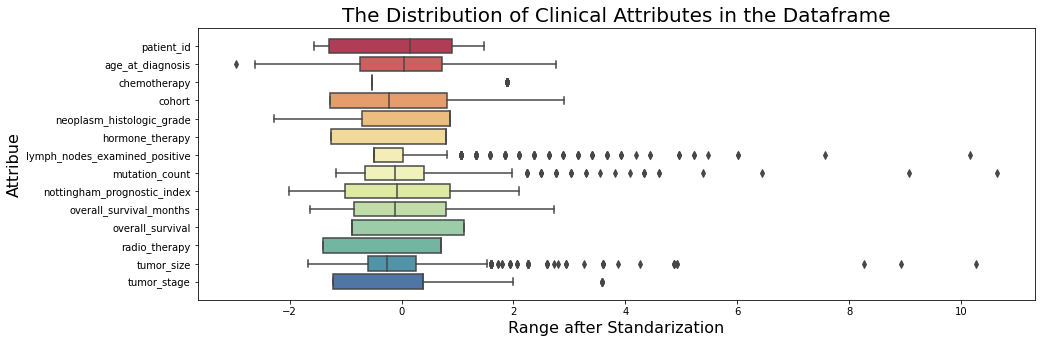

In [7]:
df = df.dropna()

ax, fig = plt.subplots(1, 1, figsize = (15, 5))
plt.title('The Distribution of Clinical Attributes in the Dataframe', fontsize = 20) #Change please

sns.boxplot(y = "variable", x = "value", data = pd.melt(to_standard(df.iloc[:, :31])), palette = 'Spectral')
plt.xlabel('Range after Standarization', size = 16)
plt.ylabel('Attribue', size = 16)

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

In [8]:
mask_df = (df[['tumor_size', 'mutation_count', 'lymph_nodes_examined_positive']].apply(zscore) < 3)
mask_df['Drop'] = True
for col in mask_df:
    mask_df['Drop'] &= mask_df[f"{col}"]
df_zscore = df[mask_df['Drop']]
print("df shape: ", df.shape)
print("df after zscore shape: ", df_zscore.shape)
print("Number of outliers that have been removed: ", df.shape[0]-df_zscore.shape[0])

df shape:  (1092, 693)
df after zscore shape:  (1034, 693)
Number of outliers that have been removed:  58


In [9]:
Q1 = df['tumor_size'].quantile(0.25)
Q3 = df['tumor_size'].quantile(0.75)
IQR = Q3 - Q1
filtered = df.query(f'(@Q1 - 1.5 * @IQR) <= tumor_size <= (@Q3 + 1.5 * @IQR)')
Q1 = filtered['mutation_count'].quantile(0.25)
Q3 = filtered['mutation_count'].quantile(0.75)
IQR = Q3 - Q1
filtered = filtered.query(f'(@Q1 - 1.5 * @IQR) <= mutation_count <= (@Q3 + 1.5 * @IQR)')
Q1 = filtered['lymph_nodes_examined_positive'].quantile(0.25)
Q3 = filtered['lymph_nodes_examined_positive'].quantile(0.75)
IQR = Q3 - Q1
df_IQR = filtered.query(f'(@Q1 - 1.5 * @IQR) <= lymph_nodes_examined_positive <= (@Q3 + 1.5 * @IQR)')
print("df shape: ", df.shape)
print("df after IQR shape: ", df_IQR.shape)
print("Number of outliers that have been removed: ", df.shape[0]-df_IQR.shape[0])

df shape:  (1092, 693)
df after IQR shape:  (901, 693)
Number of outliers that have been removed:  191


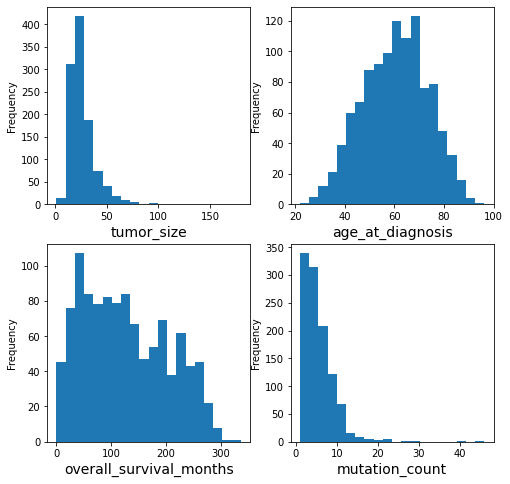

In [10]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(8, 8))

i, j = 0, 0
for col in df[['tumor_size', 'age_at_diagnosis', 'overall_survival_months', 'mutation_count']]:
    if j == 2:
        j = 0
        i = 1
    df[col].plot(kind='hist', bins=20, ax=ax[i, j])
    ax[i,j].set_xlabel(col, size=14)
    j += 1

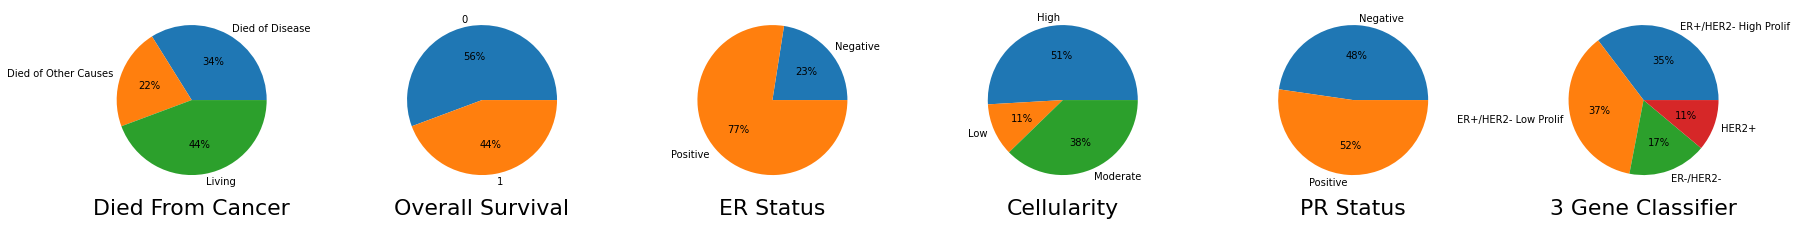

In [11]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(ncols=6, figsize=(25, 25))
df.groupby('death_from_cancer').size().plot(kind='pie', autopct='%1.0f%%', ax=ax1)
df.groupby('overall_survival').size().plot(kind='pie', autopct='%1.0f%%', ax=ax2)
df.groupby('er_status').size().plot(kind='pie', autopct='%1.0f%%', ax=ax3)
df.groupby('cellularity').size().plot(kind='pie', autopct='%1.0f%%', ax=ax4)
df.groupby('pr_status').size().plot(kind='pie', autopct='%1.0f%%', ax=ax5)
df.groupby('3-gene_classifier_subtype').size().plot(kind='pie', autopct='%1.0f%%', ax=ax6)

fig.patch.set_facecolor('xkcd:white')

ax1.set_xlabel('Died From Cancer', size=22)
ax2.set_xlabel('Overall Survival', size=22)
ax3.set_xlabel('ER Status', size=22)
ax4.set_xlabel('Cellularity', size=22)
ax5.set_xlabel('PR Status', size=22)
ax6.set_xlabel('3 Gene Classifier', size=22)
ax1.set_ylabel('')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')
ax5.set_ylabel('')
ax6.set_ylabel('')
plt.tight_layout()
plt.show()

In [12]:
import jenkspy
columns = ['tumor_size', 'age_at_diagnosis', 'overall_survival_months', 'mutation_count']
for col in columns:
    breaks = jenkspy.jenks_breaks(df[col], nb_class=3)
    df[f'{col}_natural_breaks'] = pd.cut(df[col], bins=breaks, 
                                         labels=[f'{breaks[0]}, {breaks[1]}', f'{breaks[1]:.2f}, {breaks[2]:.2f}', f'{breaks[2]:.2f}, {breaks[3]:.2f}'], 
                                         include_lowest=True)

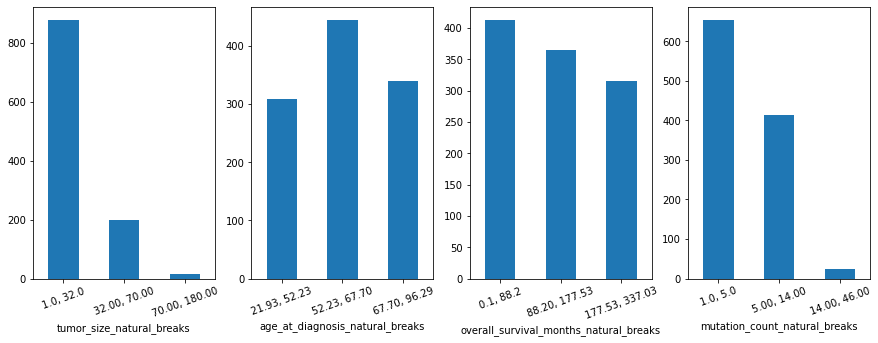

In [13]:
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(15, 5))

columns = ['tumor_size_natural_breaks', 'age_at_diagnosis_natural_breaks', 'overall_survival_months_natural_breaks', 'mutation_count_natural_breaks']
j = 0
for col in columns:
    df.groupby(col).size().plot(kind='bar', ax=ax[j], rot=20)
    ax[j].set_xlabel(col, size=10)
    j+=1

In [14]:
df = pd.DataFrame(df_zscore)
mutation_df = df.drop(df.columns[:520], axis=1)
df = df.drop(df.columns[31:], axis=1)

In [15]:
# Convert Categorical Data to Numerical
df['pr_status'] = np.where(df["pr_status"] == 'Positive', 1, -1)
df['er_status'] = np.where(df["er_status"] == 'Positive', 1, -1)
df['her2_status'] = np.where(df["her2_status"] == 'Positive', 1, -1)
df['er_status_measured_by_ihc'] = np.where(df['er_status_measured_by_ihc'] == 'Positve', 1, -1)
df['cellularity'] = np.select([df['cellularity'] == 'High', df['cellularity'] == 'Moderate', df['cellularity'] == 'Low'], [2, 1, 0])

one_hot = pd.get_dummies(df['3-gene_classifier_subtype'])
df.drop(['3-gene_classifier_subtype'], axis=1, inplace=True)
df = df.join(one_hot)

In [16]:
df = df.drop(['patient_id', 'type_of_breast_surgery', 'cancer_type', 'cancer_type_detailed', 
        'pam50_+_claudin-low_subtype', 'tumor_other_histologic_subtype', 'her2_status_measured_by_snp6', 'inferred_menopausal_state',
        'death_from_cancer', 'oncotree_code', 'integrative_cluster', 'primary_tumor_laterality'], axis=1)

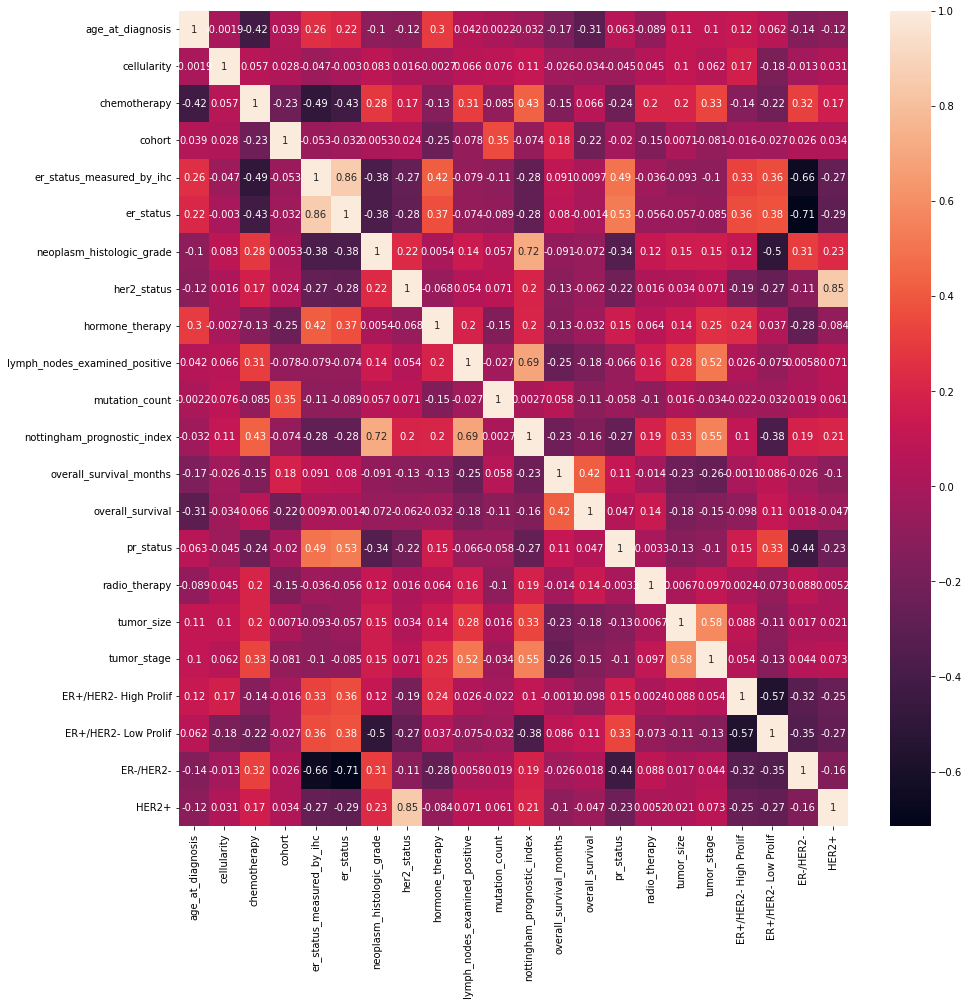

In [17]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),annot=True);

# Phase 2

### Cross Validation

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#we use it in the future 

In [19]:
# MinMaxScaler().fit_transform(df)
# df['overall_survival']


from sklearn.model_selection import train_test_split

X = df.drop(['overall_survival'], axis=1)
X = MinMaxScaler().fit_transform(X)
Y = df['overall_survival']


x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)

### Baseline

In [20]:
from sklearn.dummy import DummyClassifier
DummyClassifier(strategy="most_frequent").fit(X, Y).score(X, Y)

0.5435203094777563

### Models

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

BOLD = '\033[1m'
END = '\033[0m'

## KNN Model

Model = KNN 
CV scores:  [0.66666667 0.61835749 0.67149758 0.72463768 0.63592233]
CV Mean score:  0.6634163500773884
Classification Report:  
              precision    recall  f1-score   support

           0       0.68      0.70      0.69       113
           1       0.62      0.60      0.61        94

    accuracy                           0.65       207
   macro avg       0.65      0.65      0.65       207
weighted avg       0.65      0.65      0.65       207

Model's score on train data : 1.0
Model's score on test data :  0.6521739130434783
Best KNN model parameters: 
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 35, 'p': 2, 'weights': 'distance'}


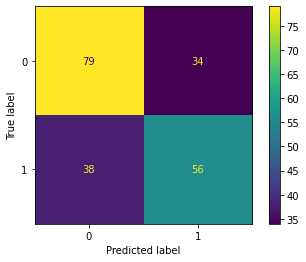

In [22]:
params = {
    "n_neighbors" : [5,15,25,30,35,40, 100],
    "weights" : ["uniform" , "distance"]
}

model = GridSearchCV(KNeighborsClassifier(), params, n_jobs=-1, cv=4).fit(x_train, y_train)
pred = model.predict(x_test)
results = cross_val_score(model, X, Y, cv=kfold)

knn_pred = model.predict(x_test)
knn_test = model.score(x_test, y_test)
knn_train = results.mean()

print(BOLD + "Model = KNN", END)
print("CV scores: ", results)
print("CV Mean score: ", results.mean())
print('Classification Report:  ')
print(classification_report(y_test, pred))
print("Model's score on train data :", model.score(x_train, y_train))
print("Model's score on test data : ", model.score(x_test, y_test))
cm = confusion_matrix(y_test, pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
print("Best KNN model parameters: ")
print(model.best_estimator_.get_params())
disp.plot();

Model = Logistic Regression
CV scores:  [0.73493976 0.8253012  0.76969697 0.81212121 0.70909091]
CV Mean score:  0.7702300109529026
Classification Report:  
              precision    recall  f1-score   support

           0       0.77      0.72      0.74       113
           1       0.69      0.74      0.71        94

    accuracy                           0.73       207
   macro avg       0.73      0.73      0.73       207
weighted avg       0.73      0.73      0.73       207

Model's score on train data : 0.777509068923821
Model's score on test data :  0.7294685990338164
Best Logistic Regression model parameters: 
{'C': 0.9947368421052631, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 10000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


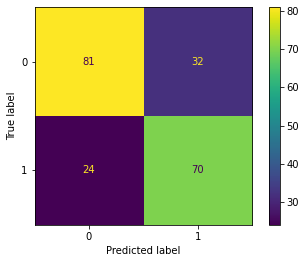

In [23]:
MODEL = "Logistic Regression"
params = {
    "C" : np.linspace(0.1, 1.8, 20)
}
model = GridSearchCV(LogisticRegression(max_iter=10000), params, n_jobs=-1, cv=4).fit(x_train, y_train)
pred = model.predict(x_test)
results = cross_val_score(model, x_train, y_train, cv=kfold)

lr_pred = model.predict(x_test)
lr_test = model.score(x_test, y_test)
lr_train = results.mean()

print(BOLD + f"Model = {MODEL}" + END)
print("CV scores: ", results)
print("CV Mean score: ", results.mean())
print('Classification Report:  ')
print(classification_report(y_test, pred))
print("Model's score on train data :", model.score(x_train, y_train))
print("Model's score on test data : ", model.score(x_test, y_test))
cm = confusion_matrix(y_test, pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
print(f"Best {MODEL} model parameters: ")
print(model.best_estimator_.get_params())
disp.plot();

Model = Decision Tree Classifier
CV scores:  [0.65060241 0.63855422 0.77575758 0.67878788 0.71515152]
CV Mean score:  0.6917707192405989
Classification Report:  
              precision    recall  f1-score   support

           0       0.70      0.65      0.67       113
           1       0.61      0.66      0.63        94

    accuracy                           0.65       207
   macro avg       0.65      0.65      0.65       207
weighted avg       0.66      0.65      0.65       207

Model's score on train data : 1.0
Model's score on test data :  0.6521739130434783
Best Decision Tree Classifier model parameters: 
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


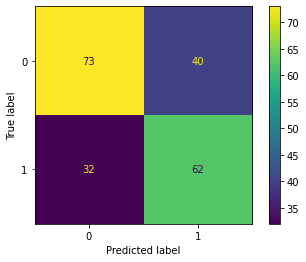

In [24]:
MODEL = "Decision Tree Classifier"

model = DecisionTreeClassifier().fit(x_train, y_train)
pred = model.predict(x_test)
results = cross_val_score(model, x_train, y_train, cv=kfold)


dt_pred = model.predict(x_test)
dt_test = model.score(x_test, y_test)
dt_train = results.mean()

print(BOLD + f"Model = {MODEL}" + END)
print("CV scores: ", results)
print("CV Mean score: ", results.mean())
print('Classification Report:  ')
print(classification_report(y_test, pred))
print("Model's score on train data :", model.score(x_train, y_train))
print("Model's score on test data : ", model.score(x_test, y_test))
cm = confusion_matrix(y_test, pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
print(f"Best {MODEL} model parameters: ")
print(model.get_params())
disp.plot();

Model = Random Forest Classifier
CV scores:  [0.74698795 0.80120482 0.78787879 0.84848485 0.8       ]
CV Mean score:  0.7969112814895947
Classification Report:  
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       113
           1       0.76      0.80      0.78        94

    accuracy                           0.79       207
   macro avg       0.79      0.79      0.79       207
weighted avg       0.79      0.79      0.79       207

Model's score on train data : 1.0
Model's score on test data :  0.7922705314009661
Best Random Forest Classifier model parameters: 
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_s

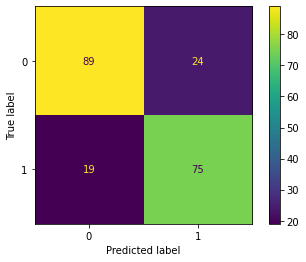

In [25]:
MODEL = "Random Forest Classifier"

model = RandomForestClassifier().fit(x_train, y_train)
pred = model.predict(x_test)
results = cross_val_score(model, x_train, y_train, cv=kfold)

rf_pred = model.predict(x_test)
rf_test = model.score(x_test, y_test)
rf_train = results.mean()

print(BOLD + f"Model = {MODEL}" + END)
print("CV scores: ", results)
print("CV Mean score: ", results.mean())
print('Classification Report:  ')
print(classification_report(y_test, pred))
print("Model's score on train data :", model.score(x_train, y_train))
print("Model's score on test data : ", model.score(x_test, y_test))
cm = confusion_matrix(y_test, pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
print(f"Best {MODEL} model parameters: ")
print(model.get_params())
disp.plot();

Model = MLP Classifier
CV scores:  [0.68072289 0.73493976 0.72727273 0.74545455 0.76363636]
CV Mean score:  0.7304052573932093
Classification Report:  
              precision    recall  f1-score   support

           0       0.77      0.65      0.71       113
           1       0.65      0.77      0.70        94

    accuracy                           0.71       207
   macro avg       0.71      0.71      0.71       207
weighted avg       0.72      0.71      0.71       207

Model's score on train data : 0.969770253929867
Model's score on test data :  0.7053140096618358
Best MLP Classifier model parameters: 
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100, 200, 100, 50, 10), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 1000, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 

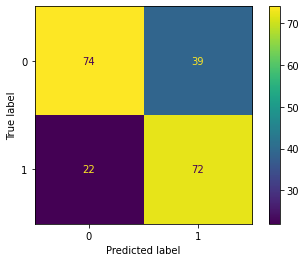

In [26]:
MODEL = "MLP Classifier"

# , (100, 100, 50, 50, 10), (150, 100, 70, 50, 10)
# , 1e-2, 1e-1, 1
# params = {
#     "hidden_layer_sizes" : [(100, 200, 100, 50, 10)],
#     "solver" : ['adam'],
#     "alpha" : [1e-4, 1e-3],
#     "learning_rate_init" : [1e-3, 1e-2, 1e-1],
#     "max_iter" : [1000,]
# }
# model = GridSearchCV(MLPClassifier(), params, n_jobs=-1, cv=4).fit(x_train, y_train)
model = MLPClassifier(hidden_layer_sizes=(100, 200, 100, 50, 10), max_iter=1000).fit(x_train, y_train)
pred = model.predict(x_test)
results = cross_val_score(model, x_train, y_train, cv=kfold)

mlp_pred = model.predict(x_test)
mlp_test = model.score(x_test, y_test)
mlp_train = results.mean()

print(BOLD + f"Model = {MODEL}" + END)
print("CV scores: ", results)
print("CV Mean score: ", results.mean())
print('Classification Report:  ')
print(classification_report(y_test, pred))
print("Model's score on train data :", model.score(x_train, y_train))
print("Model's score on test data : ", model.score(x_test, y_test))
cm = confusion_matrix(y_test, pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
print(f"Best {MODEL} model parameters: ")
print(model.get_params())
disp.plot();

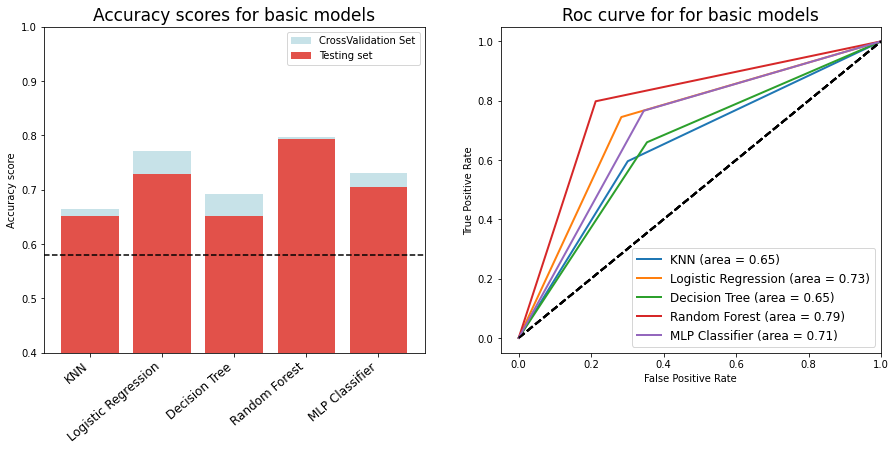

In [27]:
from sklearn.metrics import auc, roc_curve

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15,6))

color= "Spectral"


#bar chart of accuracy scores
inds = range(1,6)
labels = ["KNN", "Logistic Regression", "Decision Tree", "Random Forest", "MLP Classifier"]

scores_all = [knn_train, lr_train, dt_train, rf_train, mlp_train]
scores_predictive = [knn_test, lr_test, dt_test, rf_test, mlp_test]

ax1.bar(inds, scores_all, color=sns.color_palette(color)[5], alpha=0.3, hatch="x", edgecolor="none",label="CrossValidation Set")
ax1.bar(inds, scores_predictive, color=sns.color_palette(color)[0], label="Testing set")
ax1.set_ylim(0.4, 1)
ax1.set_ylabel("Accuracy score")
ax1.axhline(0.5793, color="black", linestyle="--")
ax1.set_title("Accuracy scores for basic models", fontsize=17)
ax1.set_xticks(range(1,6))
ax1.set_xticklabels(labels, size=12, rotation=40, ha="right")
ax1.legend()

labels = ["KNN", "Logistic Regression", "Decision Tree", "Random Forest", "MLP Classifier"]
for label, pred in zip(labels, [knn_pred, lr_pred, dt_pred, rf_pred, mlp_pred]):
    fpr, tpr, threshold = roc_curve(y_test.values, pred)
    roc_auc = auc(fpr, tpr)
    ax2.plot(fpr, tpr, label=label+' (area = %0.2f)' % roc_auc, linewidth=2)
    ax2.plot([0, 1], [0, 1], 'k--', linewidth=2)
    ax2.set_xlim([-0.05, 1.0])
    ax2.set_ylim([-0.05, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.legend(loc="lower right", prop={'size': 12})
    ax2.set_title("Roc curve for for basic models", fontsize=17)

plt.show()


In [28]:
for column in mutation_df.columns:
    mutation_df[column]=pd.to_numeric(mutation_df[column], errors='coerce').fillna(1).astype(int)

In [29]:
new_df = pd.concat([df, mutation_df], axis=1)
new_df

,age_at_diagnosis,cellularity,chemotherapy,cohort,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,her2_status,hormone_therapy,lymph_nodes_examined_positive,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
1,43.19,2,0,1.0,1,1,3.0,-1,1,0.0,...,0,0,0,0,0,0,0,0,0,0
4,76.97,2,1,1.0,1,1,3.0,-1,1,8.0,...,0,0,0,0,0,0,0,0,0,0
5,78.77,1,0,1.0,1,1,3.0,-1,1,0.0,...,0,0,0,0,0,0,0,0,0,0
8,86.41,1,0,1.0,1,1,3.0,-1,1,1.0,...,0,0,0,0,0,0,0,0,0,0
9,84.22,2,0,1.0,-1,1,2.0,-1,0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1618,71.22,2,0,5.0,1,1,2.0,-1,1,4.0,...,0,0,0,0,0,0,0,0,0,0
1619,70.65,2,0,5.0,1,1,1.0,-1,0,0.0,...,0,0,0,0,0,0,0,0,0,0
1621,75.62,2,0,5.0,-1,-1,3.0,-1,0,0.0,...,0,0,0,0,0,0,0,0,0,0
1623,52.84,2,1,5.0,1,1,2.0,-1,0,6.0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
from sklearn.model_selection import train_test_split

X = new_df.drop(['overall_survival'], axis=1)
X = MinMaxScaler().fit_transform(X)
Y = new_df['overall_survival']


x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)

Model = MLP Classifier
CV scores:  [0.63253012 0.68674699 0.63636364 0.64848485 0.6969697 ]
CV Mean score:  0.6602190580503834
Classification Report:  
              precision    recall  f1-score   support

           0       0.68      0.81      0.74       113
           1       0.70      0.55      0.62        94

    accuracy                           0.69       207
   macro avg       0.69      0.68      0.68       207
weighted avg       0.69      0.69      0.68       207

Model's score on train data : 0.750906892382104
Model's score on test data :  0.6908212560386473
Best MLP Classifier model parameters: 
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': True, 'epsilon': 1e-08, 'hidden_layer_sizes': (100, 200, 100, 50, 10), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 1000, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, '

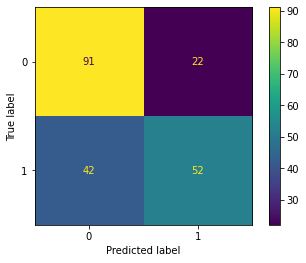

In [31]:
MODEL = "MLP Classifier"

# , (100, 100, 50, 50, 10), (150, 100, 70, 50, 10)
# , 1e-2, 1e-1, 1
# params = {
#     "hidden_layer_sizes" : [(100, 200, 100, 50, 10)],
#     "solver" : ['adam'],
#     "alpha" : [1e-4, 1e-3],
#     "learning_rate_init" : [1e-3, 1e-2, 1e-1],
#     "max_iter" : [1000,]
# }
# model = GridSearchCV(MLPClassifier(), params, n_jobs=-1, cv=4).fit(x_train, y_train)
model = MLPClassifier(hidden_layer_sizes=(100, 200, 100, 50, 10), max_iter=1000, early_stopping=True).fit(x_train, y_train)
pred = model.predict(x_test)
results = cross_val_score(model, x_train, y_train, cv=kfold)

mlp_pred = model.predict(x_test)
mlp_test = model.score(x_test, y_test)
mlp_train = results.mean()

print(BOLD + f"Model = {MODEL}" + END)
print("CV scores: ", results)
print("CV Mean score: ", results.mean())
print('Classification Report:  ')
print(classification_report(y_test, pred))
print("Model's score on train data :", model.score(x_train, y_train))
print("Model's score on test data : ", model.score(x_test, y_test))
cm = confusion_matrix(y_test, pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
print(f"Best {MODEL} model parameters: ")
print(model.get_params())
disp.plot();

In [32]:
from sklearn.decomposition import PCA

pca = PCA(120).fit(X)
print(f"{pca.explained_variance_ratio_[:120].sum()=}")
X = pca.transform(X)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)

pca.explained_variance_ratio_[:120].sum()=0.9545777618026642


Model = MLP Classifier
CV scores:  [0.6746988  0.70481928 0.75151515 0.71515152 0.75757576]
CV Mean score:  0.7207520993063161
Classification Report:  
              precision    recall  f1-score   support

           0       0.73      0.81      0.77       113
           1       0.73      0.65      0.69        94

    accuracy                           0.73       207
   macro avg       0.73      0.73      0.73       207
weighted avg       0.73      0.73      0.73       207

Model's score on train data : 0.9153567110036276
Model's score on test data :  0.7342995169082126
Best MLP Classifier model parameters: 
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': True, 'epsilon': 1e-08, 'hidden_layer_sizes': (100, 200, 100, 50, 10), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 1000, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 

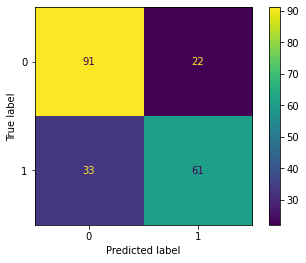

In [33]:
MODEL = "MLP Classifier"

# , (100, 100, 50, 50, 10), (150, 100, 70, 50, 10)
# , 1e-2, 1e-1, 1
# params = {
#     "hidden_layer_sizes" : [(100, 200, 100, 50, 10)],
#     "solver" : ['adam'],
#     "alpha" : [1e-4, 1e-3],
#     "learning_rate_init" : [1e-3, 1e-2, 1e-1],
#     "max_iter" : [1000,]
# }
# model = GridSearchCV(MLPClassifier(), params, n_jobs=-1, cv=4).fit(x_train, y_train)
# 
model = MLPClassifier(hidden_layer_sizes=(100, 200, 100, 50, 10), max_iter=1000, early_stopping=True).fit(x_train, y_train)
pred = model.predict(x_test)
results = cross_val_score(model, x_train, y_train, cv=kfold)

mlp_pred = model.predict(x_test)
mlp_test = model.score(x_test, y_test)
mlp_train = results.mean()

print(BOLD + f"Model = {MODEL}" + END)
print("CV scores: ", results)
print("CV Mean score: ", results.mean())
print('Classification Report:  ')
print(classification_report(y_test, pred))
print("Model's score on train data :", model.score(x_train, y_train))
print("Model's score on test data : ", model.score(x_test, y_test))
cm = confusion_matrix(y_test, pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
print(f"Best {MODEL} model parameters: ")
print(model.get_params())
disp.plot();